# Exploratory Data Analysis

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # plot formatting
from datetime import date, timedelta
from scipy.stats import norm, skew, shapiro

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold, ShuffleSplit, RepeatedKFold, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# for working from google drive
from google.colab import drive
drive.mount('/content/drive')
 

Mounted at /content/drive


In [3]:
vm = pd.read_csv("/content/drive/Shareddrives/VoltMotor/Data/VoltMotor_YeniData_08072022.csv",header=None,names=["Serial_id","Serial_no","Material_code","prod_date","sup_id","out_date","delivery_doc_no","dlv_date","Stok","material_id"])
vm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2209489 entries, 0 to 2209488
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Serial_id        int64  
 1   Serial_no        object 
 2   Material_code    object 
 3   prod_date        object 
 4   sup_id           float64
 5   out_date         object 
 6   delivery_doc_no  object 
 7   dlv_date         object 
 8   Stok             object 
 9   material_id      int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 168.6+ MB


In [4]:
vm["material_id"].nunique()

4973

In [5]:
# Removing the ones that do not have Production and Shipping Date
vm = vm[~(vm[["out_date","prod_date"]].isna()).any(axis=1)]

In [6]:
vm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 702003 entries, 3 to 2209482
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Serial_id        702003 non-null  int64  
 1   Serial_no        702003 non-null  object 
 2   Material_code    702003 non-null  object 
 3   prod_date        702003 non-null  object 
 4   sup_id           702003 non-null  float64
 5   out_date         702003 non-null  object 
 6   delivery_doc_no  312517 non-null  object 
 7   dlv_date         702003 non-null  object 
 8   Stok             117 non-null     object 
 9   material_id      702003 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 58.9+ MB


In [7]:
vm.shape

(702003, 10)

In [8]:
vm.head()

,Serial_id,Serial_no,Material_code,prod_date,sup_id,out_date,delivery_doc_no,dlv_date,Stok,material_id
3,4189197,MP02682307,VSPA90S4AB348MIS,2020-12-23 22:21:28.457,4214401.0,2020-12-30 07:57:45.033,0070084644,2020-08-12 00:00:00.000,NaN,70895
9,5458330,MP03363368,MM1G1C1201101,2021-08-03 14:36:56.900,5458347.0,2021-08-05 13:07:33.157,0070094554,2021-01-28 00:00:00.000,NaN,16449
13,235185,MP00223120,MM1G1B1400250,2017-10-24 12:51:11.463,235044.0,2017-10-25 12:27:04.873,0070041088,2017-09-28 00:00:00.000,NaN,16414
14,1979672,MP01463118,V2EA90S4CB3440BF,2019-09-20 12:58:38.743,1979390.0,2019-11-01 08:26:08.500,NaN,2019-10-30 00:00:00.000,NaN,64237
16,109213,MP00101716,MM1G1F1402200,2017-08-10 17:34:18.770,109325.0,2017-10-11 08:00:49.017,NaN,2017-10-09 00:00:00.000,NaN,16549


## Motor Features

In [9]:
mf = pd.read_excel('/content/drive/Shareddrives/VoltMotor/Data/MotorFeatures.xlsx')

In [10]:
mf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4141 entries, 0 to 4140
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   material id     4140 non-null   float64
 1   material no     4140 non-null   object 
 2   definition      4140 non-null   object 
 3   Güç [kW]        4136 non-null   object 
 4   Kutup Sayısı    4125 non-null   object 
 5   Verim Sınıfı    3841 non-null   object 
 6   Gövde           4134 non-null   object 
 7   Yapı Şekli      4140 non-null   object 
 8   Kutup Sayısı.1  4141 non-null   object 
dtypes: float64(1), object(8)
memory usage: 291.3+ KB


In [11]:
mf.head()

,material id,material no,definition,Güç [kW],Kutup Sayısı,Verim Sınıfı,Gövde,Yapı Şekli,Kutup Sayısı.1
0,85376.0,V1EA71M4BB541,"X0,37KW 4P TRF 71 METAL TASLI IE1 B5",0.37,4P,IE1,71M,Al,4P
1,84451.0,V2EA90L4FB3440YY,"1,5KW 4P TRF 90L 2/4V IE2 YY B34",1.5,4P,IE2,90L,Al,4P
2,84783.0,V1EA80M4AB3480SYY,"1,1KW 4P 80 2/4V S3 75% SY YY B34",1.1,4P,IE1,80M,Al,4P
3,99579.0,V2EA132S2BB342AI,"7,5KW 2P 132S DAİRETEST4/6V IE2 AI MÜŞ.T",7.5,2P,IE2,132S,Al,2P
4,97255.0,VSSA100L4CB3540CN,"X2,2 KW 4P MON S+DD 100 B35 CN",2.2,4P,YOK,100L,Al,4P


In [12]:
# for ind in mf.index:
#     if mf['Kutup Sayısı'][ind] != mf['Kutup Sayısı.1'][ind]:
#       print(mf['material_id'][ind])
#       print("Two columns are not equal for each row")
#       if True:
#         break

In [13]:
# def split_df(df, chunk_size = 10000): 
#     chunks = list()
#     num_chunks = len(df) // chunk_size + 1
#     for i in range(num_chunks):
#         chunks.append(df[i*chunk_size:(i+1)*chunk_size])
#     return chunks

#     df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8 = split_df(fm, chunk_size = 100000)

In [14]:
mf.rename(columns={'material id': 'material_id'}, inplace=True)

In [15]:
merged_df = pd.merge(vm, mf, how='inner', on='material_id')

In [16]:
merged_df['material_id'].nunique()

2451

## MotorFeatures Data From SQL for Weight Property

In [17]:
mf_sql = pd.read_csv('/content/drive/Shareddrives/VoltMotor/Data/MotorFeaturesFromSQL.csv',names=["material_id","AGIRLIK","GOVDE","KUTUP_SAYISI","GUC","YAPI_SEKLI","VERIM_SINIFI"])

In [18]:
mf_sql.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9391 entries, 0 to 9390
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   material_id   8436 non-null   float64
 1   AGIRLIK       8153 non-null   object 
 2   GOVDE         1713 non-null   object 
 3   KUTUP_SAYISI  1711 non-null   object 
 4   GUC           1711 non-null   object 
 5   YAPI_SEKLI    1710 non-null   object 
 6   VERIM_SINIFI  1711 non-null   object 
dtypes: float64(1), object(6)
memory usage: 513.7+ KB


In [19]:
mf_sql = mf_sql[['material_id','AGIRLIK']]
mf_sql.head()

,material_id,AGIRLIK
0,17244.0,"6,0"
1,17246.0,"6,0"
2,17261.0,"9,0"
3,17295.0,"10,0"
4,17327.0,"4,0"


In [20]:
final_df1 = pd.merge(merged_df, mf_sql,how='left', on='material_id')

In [21]:
dff = pd.read_csv('/content/drive/Shareddrives/VoltMotor/volt_motor_veri_v2.csv')

In [22]:
dff.head()

,serial_id,Motor_Kodu,material_id,material_qty,material_unit,Urun_Tipi,operation_type,operation_type_def,Depoya_Giris_Tarihi,area_id,...,Depodan_Cikis_Tarihi,Cikis_IO,rn,AGIRLIK,TOPLAM_AGIRLIK,GOVDE,KUTUP_SAYISI,GUC,YAPI_SEKLI,VERIM_SINIFI
0,3,U0001,2022,5,AD,Ürün,T101,Sağlam Transfer Onayı,2017-04-04 14:15:19.897,24,...,2017-04-04 14:29:33.743,O,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4,MLZ001,2023,5,AD,Ürün,T001,Depo Transfer,2017-04-04 13:48:23.450,24,...,2017-04-04 14:31:20.377,O,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6,MLZ001,2023,1,AD,Ürün,T001,Depo Transfer,2017-04-05 10:50:07.867,24,...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10,MLZ001,2023,5,AD,Ürün,T001,Depo Transfer,2017-04-05 10:49:46.623,24,...,2017-04-05 10:56:44.280,O,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,300,MM2G1A1400182,16677,1,AD,Ürün,T001,Depo Transfer,2017-05-06 10:40:30.343,24,...,NaN,NaN,1,"4,0",4.0,63M,4P,0.18,B34,-


In [23]:
dff = dff[["material_id", "TOPLAM_AGIRLIK"]]
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141254 entries, 0 to 141253
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   material_id     141254 non-null  int64  
 1   TOPLAM_AGIRLIK  141058 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 2.2 MB


In [24]:
dff["material_id"].nunique()

5417

In [25]:
  df1 = dff.groupby('material_id')["TOPLAM_AGIRLIK"].mean().reset_index()
  df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5417 entries, 0 to 5416
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   material_id     5417 non-null   int64  
 1   TOPLAM_AGIRLIK  5318 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 84.8 KB


In [26]:
final_df = pd.merge(final_df1, df1,how='left', on='material_id')

In [27]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324453 entries, 0 to 324452
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Serial_id        324453 non-null  int64  
 1   Serial_no        324453 non-null  object 
 2   Material_code    324453 non-null  object 
 3   prod_date        324453 non-null  object 
 4   sup_id           324453 non-null  float64
 5   out_date         324453 non-null  object 
 6   delivery_doc_no  147448 non-null  object 
 7   dlv_date         324453 non-null  object 
 8   Stok             63 non-null      object 
 9   material_id      324453 non-null  int64  
 10  material no      324453 non-null  object 
 11  definition       324453 non-null  object 
 12  Güç [kW]         324395 non-null  object 
 13  Kutup Sayısı     324389 non-null  object 
 14  Verim Sınıfı     301270 non-null  object 
 15  Gövde            324452 non-null  object 
 16  Yapı Şekli       324453 non-null  obje

In [28]:
final_df.head()

,Serial_id,Serial_no,Material_code,prod_date,sup_id,out_date,delivery_doc_no,dlv_date,Stok,material_id,material no,definition,Güç [kW],Kutup Sayısı,Verim Sınıfı,Gövde,Yapı Şekli,Kutup Sayısı.1,AGIRLIK,TOPLAM_AGIRLIK
0,4189197,MP02682307,VSPA90S4AB348MIS,2020-12-23 22:21:28.457,4214401.0,2020-12-30 07:57:45.033,0070084644,2020-08-12 00:00:00.000,NaN,70895,VSPA90S4AB348MIS,"0,55KW 22X84 K.SUZ P.Ş SY SEZER S.BOYA",0.55,4P,YOK,90S,Al,,"11,0",514.858407
1,2028896,MP01487385,VSPA90S4AB348MIS,2019-10-01 15:41:46.813,2029201.0,2019-10-04 08:00:15.067,NaN,2019-09-04 00:00:00.000,NaN,70895,VSPA90S4AB348MIS,"0,55KW 22X84 K.SUZ P.Ş SY SEZER S.BOYA",0.55,4P,YOK,90S,Al,,"11,0",514.858407
2,4187902,MP02681149,VSPA90S4AB348MIS,2020-12-22 12:46:18.950,4194204.0,2020-12-31 12:32:44.090,0070084426,2020-08-12 00:00:00.000,NaN,70895,VSPA90S4AB348MIS,"0,55KW 22X84 K.SUZ P.Ş SY SEZER S.BOYA",0.55,4P,YOK,90S,Al,,"11,0",514.858407
3,5846498,MP03567646,VSPA90S4AB348MIS,2021-10-04 03:17:59.440,5847213.0,2021-10-11 08:48:42.803,0070097231,2021-05-18 00:00:00.000,NaN,70895,VSPA90S4AB348MIS,"0,55KW 22X84 K.SUZ P.Ş SY SEZER S.BOYA",0.55,4P,YOK,90S,Al,,"11,0",514.858407
4,5812118,MP03550674,VSPA90S4AB348MIS,2021-09-29 00:32:56.627,5819946.0,2021-10-05 07:34:10.020,NaN,2021-05-18 00:00:00.000,NaN,70895,VSPA90S4AB348MIS,"0,55KW 22X84 K.SUZ P.Ş SY SEZER S.BOYA",0.55,4P,YOK,90S,Al,,"11,0",514.858407


In [29]:
final_df.shape

(324453, 20)

In [30]:
final_df['material_id'].nunique()

2451

In [31]:
# Drop all row with "GEÇERSİZ"
final_df = final_df[(final_df != 'GEÇERSİZ').all(axis=1)]

In [32]:
final_df.shape

(290522, 20)

In [33]:
final_df.isna().sum()

Serial_id               0
Serial_no               0
Material_code           0
prod_date               0
sup_id                  0
out_date                0
delivery_doc_no    154360
dlv_date                0
Stok               290461
material_id             0
material no             0
definition              0
Güç [kW]               58
Kutup Sayısı           64
Verim Sınıfı        23183
Gövde                   1
Yapı Şekli              0
Kutup Sayısı.1          0
AGIRLIK                66
TOPLAM_AGIRLIK          0
dtype: int64

In [34]:
for i in final_df.columns:
  print(i,":",final_df[i].unique())

Serial_id : [4189197 2028896 4187902 ... 2948686 1692885 1711777]
Serial_no : ['MP02682307' 'MP01487385' 'MP02681149' ... 'MP01984722' 'MP01318877'
 'MP01328345']
Material_code : ['VSPA90S4AB348MIS' 'V2EA90S4CB3440BF' 'V2EA100L4JB3440AI' ...
 'V1EA71M2CB34KSB' 'V3EA132S2DB346KSB' 'V2EA132S4GB3566UL']
prod_date : ['2020-12-23 22:21:28.457' '2019-10-01 15:41:46.813'
 '2020-12-22 12:46:18.950' ... '2020-04-29 16:08:11.040'
 '2019-06-21 16:02:02.453' '2019-06-28 11:07:09.850']
sup_id : [4214401. 2029201. 4194204. ... 2954560. 1692908. 1713797.]
out_date : ['2020-12-30 07:57:45.033' '2019-10-04 08:00:15.067'
 '2020-12-31 12:32:44.090' ... '2021-06-21 09:21:08.617'
 '2020-05-04 07:48:09.520' '2019-06-25 08:25:30.163']
delivery_doc_no : ['0070084644' nan '0070084426' ... '0070072819' '0070092691' '0070073434']
dlv_date : ['2020-08-12 00:00:00.000' '2019-09-04 00:00:00.000'
 '2021-05-18 00:00:00.000' ... '2021-02-19 00:00:00.000'
 '2017-06-01 00:00:00.000' '2020-03-27 00:00:00.000']
Stok : [na

In [35]:
# Correcting format of 160W as other power values
final_df.loc[final_df['Güç [kW]'] == '160W', 'Güç [kW]'] = 0.16

In [36]:
final_df.shape

(290522, 20)

### Filling Empty Kutup Sayısı.1 feature if Kutup Sayısı feature is not null

In [37]:
for ind in final_df.index:
    if final_df['Kutup Sayısı'][ind] != final_df['Kutup Sayısı.1'][ind]:
      print(final_df['material_id'][ind])
      print("Two columns are not equal for each row")
      if True:
        break

70895
Two columns are not equal for each row


In [38]:
final_df[final_df['Kutup Sayısı.1'] == ' ']['Kutup Sayısı.1'].count()

17597

In [39]:
print(
final_df[(final_df['Kutup Sayısı.1'] == ' ') & ~(final_df['Kutup Sayısı'].isna())]['Kutup Sayısı'].unique(),
final_df[(final_df['Kutup Sayısı.1'] == ' ') & (final_df['Kutup Sayısı'].notnull())]['Kutup Sayısı'].count(),
final_df[(final_df['Kutup Sayısı.1'] == ' ') & (final_df['Kutup Sayısı'].isnull())]['Kutup Sayısı'].count()
)

['4P' '2P' '8P'] 17539 0


In [40]:
final_df.loc[final_df['Kutup Sayısı.1'] == ' ','Kutup Sayısı.1'] = final_df[final_df['Kutup Sayısı.1'] == ' ']['Kutup Sayısı']

In [41]:
final_df[final_df['Kutup Sayısı.1'].isnull()]['Kutup Sayısı.1'].count()

0

In [42]:
final_df['Kutup Sayısı.1'].isna().sum()

58

In [43]:
df1 = final_df[~(final_df[['AGIRLIK']].isna()).any(axis=1)]

In [44]:
df1.isna().sum()

Serial_id               0
Serial_no               0
Material_code           0
prod_date               0
sup_id                  0
out_date                0
delivery_doc_no    154325
dlv_date                0
Stok               290395
material_id             0
material no             0
definition              0
Güç [kW]                5
Kutup Sayısı           11
Verim Sınıfı        23130
Gövde                   1
Yapı Şekli              0
Kutup Sayısı.1          5
AGIRLIK                 0
TOPLAM_AGIRLIK          0
dtype: int64

In [45]:
df1[df1['Kutup Sayısı.1'].isna()]

,Serial_id,Serial_no,Material_code,prod_date,sup_id,out_date,delivery_doc_no,dlv_date,Stok,material_id,material no,definition,Güç [kW],Kutup Sayısı,Verim Sınıfı,Gövde,Yapı Şekli,Kutup Sayısı.1,AGIRLIK,TOPLAM_AGIRLIK
323219,1855544,MP01401233,V1EA100M84AB351,2019-08-07 13:09:25.967,1859331.0,2019-08-19 08:00:06.993,NaN,2019-07-18 00:00:00.000,NaN,77579,V1EA100M84AB351,"0,75-1,1 KW 8-4 TRF 100 GMM İKİ DEV. PTC","0,75-1,1",NaN,NaN,100L,Al,NaN,"17,0",170.0
323220,1855547,MP01401236,V1EA100M84AB351,2019-08-07 13:08:50.857,1859331.0,2019-08-19 08:00:06.993,NaN,2019-07-18 00:00:00.000,NaN,77579,V1EA100M84AB351,"0,75-1,1 KW 8-4 TRF 100 GMM İKİ DEV. PTC","0,75-1,1",NaN,NaN,100L,Al,NaN,"17,0",170.0
323221,1855543,MP01401232,V1EA100M84AB351,2019-08-07 13:09:34.543,1859331.0,2019-08-19 08:00:06.993,0070062354,2019-07-18 00:00:00.000,NaN,77579,V1EA100M84AB351,"0,75-1,1 KW 8-4 TRF 100 GMM İKİ DEV. PTC","0,75-1,1",NaN,NaN,100L,Al,NaN,"17,0",170.0
323222,1855546,MP01401235,V1EA100M84AB351,2019-08-07 13:09:00.950,1859331.0,2019-08-19 08:00:06.993,NaN,2019-07-18 00:00:00.000,NaN,77579,V1EA100M84AB351,"0,75-1,1 KW 8-4 TRF 100 GMM İKİ DEV. PTC","0,75-1,1",NaN,NaN,100L,Al,NaN,"17,0",170.0
324263,1288161,MP01102992,MT01000000000,2019-03-04 10:42:01.933,1288253.0,2019-03-07 07:54:08.250,NaN,2019-03-06 00:00:00.000,NaN,17065,MT01000000000,ÖZEL NUMUNE MOTOR,NaN,NaN,NaN,NaN,Al,NaN,"17,9",17.9


In [46]:
index = df1[df1['Kutup Sayısı.1'].isna()].index.tolist()

In [47]:
index

[323219, 323220, 323221, 323222, 324263]

In [48]:
df1.loc[index, 'Kutup Sayısı.1'] = '2P'

In [49]:
df1[df1['Kutup Sayısı.1'].isna()].index.tolist()

[]

In [50]:
df = df1[~(df1[['Gövde','Güç [kW]']].isna()).any(axis=1)]

In [51]:
df.loc[df['Verim Sınıfı'].isna(), 'Verim Sınıfı'] = 'YOK'

In [52]:
df.isna().sum()

Serial_id               0
Serial_no               0
Material_code           0
prod_date               0
sup_id                  0
out_date                0
delivery_doc_no    154322
dlv_date                0
Stok               290390
material_id             0
material no             0
definition              0
Güç [kW]                0
Kutup Sayısı           10
Verim Sınıfı            0
Gövde                   0
Yapı Şekli              0
Kutup Sayısı.1          0
AGIRLIK                 0
TOPLAM_AGIRLIK          0
dtype: int64

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290451 entries, 0 to 324452
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Serial_id        290451 non-null  int64  
 1   Serial_no        290451 non-null  object 
 2   Material_code    290451 non-null  object 
 3   prod_date        290451 non-null  object 
 4   sup_id           290451 non-null  float64
 5   out_date         290451 non-null  object 
 6   delivery_doc_no  136129 non-null  object 
 7   dlv_date         290451 non-null  object 
 8   Stok             61 non-null      object 
 9   material_id      290451 non-null  int64  
 10  material no      290451 non-null  object 
 11  definition       290451 non-null  object 
 12  Güç [kW]         290451 non-null  object 
 13  Kutup Sayısı     290441 non-null  object 
 14  Verim Sınıfı     290451 non-null  object 
 15  Gövde            290451 non-null  object 
 16  Yapı Şekli       290451 non-null  obje

In [54]:
df.drop('Kutup Sayısı', axis=1, inplace=True)
df.rename(columns={'Kutup Sayısı.1': 'Kutup Sayısı'}, inplace=True)

In [55]:
df[['prod_date','out_date']] = df[['prod_date','out_date']].apply(pd.to_datetime)

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290451 entries, 0 to 324452
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Serial_id        290451 non-null  int64         
 1   Serial_no        290451 non-null  object        
 2   Material_code    290451 non-null  object        
 3   prod_date        290451 non-null  datetime64[ns]
 4   sup_id           290451 non-null  float64       
 5   out_date         290451 non-null  datetime64[ns]
 6   delivery_doc_no  136129 non-null  object        
 7   dlv_date         290451 non-null  object        
 8   Stok             61 non-null      object        
 9   material_id      290451 non-null  int64         
 10  material no      290451 non-null  object        
 11  definition       290451 non-null  object        
 12  Güç [kW]         290451 non-null  object        
 13  Verim Sınıfı     290451 non-null  object        
 14  Gövde            290

In [57]:
df.isna().sum()

Serial_id               0
Serial_no               0
Material_code           0
prod_date               0
sup_id                  0
out_date                0
delivery_doc_no    154322
dlv_date                0
Stok               290390
material_id             0
material no             0
definition              0
Güç [kW]                0
Verim Sınıfı            0
Gövde                   0
Yapı Şekli              0
Kutup Sayısı            0
AGIRLIK                 0
TOPLAM_AGIRLIK          0
dtype: int64

In [58]:
# Dispatch Rate is calculated by taking the difference between the product's entry into the warehouse and shipment dates.
df['Depo_Sevk_Hızı(Gün)'] = df['out_date'] - df['prod_date']
df['Depo_Sevk_Hızı(Gün)'] = df['Depo_Sevk_Hızı(Gün)'].apply(timedelta.total_seconds)/86400

In [59]:
(df['Depo_Sevk_Hızı(Gün)'] < 0).sum()

35

In [60]:
df = df[df['Depo_Sevk_Hızı(Gün)'] > 0]
df = df[df['TOPLAM_AGIRLIK'] > 0]

In [61]:
df["TOPLAM_AGIRLIK"] = df["TOPLAM_AGIRLIK"].replace(to_replace=",", value=".", regex=True)
df[['TOPLAM_AGIRLIK']] = df[['TOPLAM_AGIRLIK']].astype(float)

df["AGIRLIK"] = df["AGIRLIK"].replace(to_replace=",", value=".", regex=True)
df[['AGIRLIK']] = df[['AGIRLIK']].astype(float)

In [62]:
df.describe()

,Serial_id,sup_id,material_id,AGIRLIK,TOPLAM_AGIRLIK,Depo_Sevk_Hızı(Gün)
count,2.904160e+05,2.904160e+05,290416.000000,290416.000000,290416.000000,290416.000000
mean,2.745501e+06,2.753736e+06,59794.366767,16.046560,485.185512,28.657343
std,1.916983e+06,1.920446e+06,30004.396506,14.142469,170.208497,48.662749
min,1.134600e+04,1.197000e+03,16589.000000,3.900000,5.000000,0.034336
25%,9.350065e+05,9.342100e+05,37833.000000,8.000000,374.000000,5.990030
50%,2.539357e+06,2.544118e+06,64742.000000,12.000000,480.606061,14.056175
75%,4.382693e+06,4.399051e+06,84415.000000,18.000000,598.240458,32.652754
max,6.684390e+06,6.684401e+06,137018.000000,679.200000,2600.000000,1326.019145


In [63]:
# Checking data types of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290416 entries, 0 to 324452
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Serial_id            290416 non-null  int64         
 1   Serial_no            290416 non-null  object        
 2   Material_code        290416 non-null  object        
 3   prod_date            290416 non-null  datetime64[ns]
 4   sup_id               290416 non-null  float64       
 5   out_date             290416 non-null  datetime64[ns]
 6   delivery_doc_no      136107 non-null  object        
 7   dlv_date             290416 non-null  object        
 8   Stok                 61 non-null      object        
 9   material_id          290416 non-null  int64         
 10  material no          290416 non-null  object        
 11  definition           290416 non-null  object        
 12  Güç [kW]             290416 non-null  object        
 13  Verim Sınıfı  

## Shipping Speed Formula

In [64]:
plt.rcParams["figure.figsize"] = (10,6)

In [65]:
df = df[df['Depo_Sevk_Hızı(Gün)'] > 0]

df["skor-1"] = (df["AGIRLIK"]/df["Depo_Sevk_Hızı(Gün)"])

df["skor"] = np.log((df["AGIRLIK"]/df["Depo_Sevk_Hızı(Gün)"])+1)

In [66]:
df1 = df[['AGIRLIK', 'Depo_Sevk_Hızı(Gün)', 'skor']]
df1.head()

,AGIRLIK,Depo_Sevk_Hızı(Gün),skor
0,11.0,6.400192,1.000153
1,11.0,2.679494,1.630270
2,11.0,8.990569,0.799084
3,11.0,7.229669,0.924857
4,11.0,6.292516,1.010913


In [67]:
df1.isna().sum()

AGIRLIK                0
Depo_Sevk_Hızı(Gün)    0
skor                   0
dtype: int64

In [68]:
df1['Depo_Sevk_Hızı(Gün)'] = df1['Depo_Sevk_Hızı(Gün)'].apply(lambda x: round(x, 0))
df1.head()

,AGIRLIK,Depo_Sevk_Hızı(Gün),skor
0,11.0,6.0,1.000153
1,11.0,3.0,1.630270
2,11.0,9.0,0.799084
3,11.0,7.0,0.924857
4,11.0,6.0,1.010913


In [69]:
df1.groupby(['AGIRLIK', 'Depo_Sevk_Hızı(Gün)'])['skor'].mean().reset_index()

,AGIRLIK,Depo_Sevk_Hızı(Gün),skor
0,3.9,46.0,0.081691
1,4.0,1.0,1.469499
2,4.0,2.0,1.151222
3,4.0,3.0,0.866664
4,4.0,4.0,0.699701
...,...,...,...
6427,625.0,11.0,4.075650
6428,679.2,27.0,3.265586
6429,679.2,35.0,3.023057
6430,679.2,52.0,2.640668


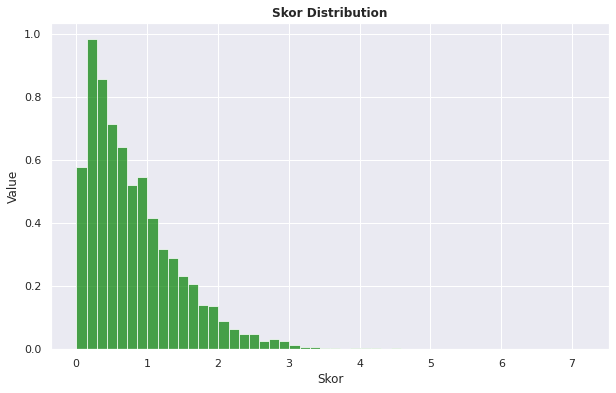

In [70]:
plt.hist(df1["skor"], bins=50, density = 1, color ='green', alpha = 0.7)
plt.xlabel('Skor')
plt.ylabel('Value')
  
plt.title('Skor Distribution',
          fontweight ="bold")

plt.show()

Text(0.5, 1.0, 'Skor distribution')

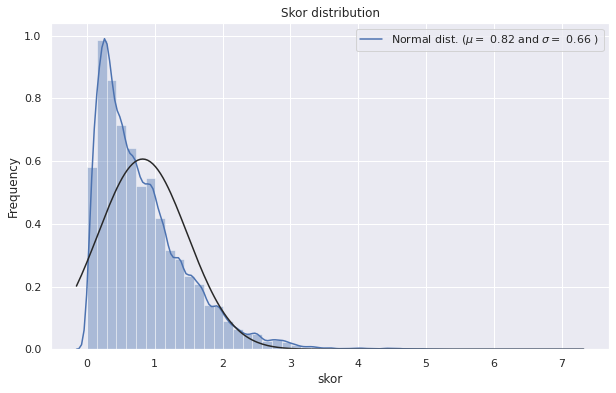

In [71]:
sns.distplot(df1['skor'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df1['skor'])

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Skor distribution')

In [72]:
# df1 = df1[df1['skor'] > 0] 

## Log Transformation

Text(0.5, 1.0, 'Log Transformed Data')

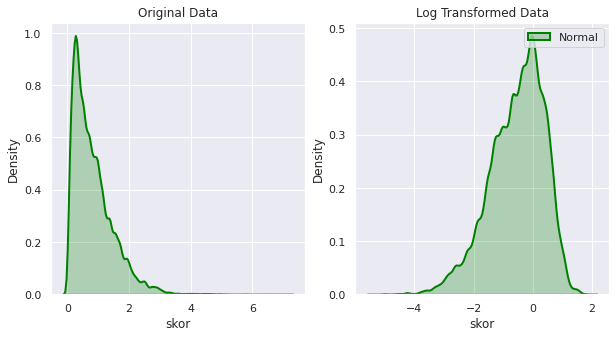

In [73]:
import numpy as np
import matplotlib.pyplot as plt

#create log-transformed data
data_log = np.log(df1['skor'])

fig, ax = plt.subplots(1, 2)
 
# plotting the original data(non-normal) and
# fitted data (normal)
sns.distplot(df1['skor'], hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "Non-Normal", color ="green", ax = ax[0])
 
sns.distplot(data_log, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "Normal", color ="green", ax = ax[1])
 
# adding legends to the subplots
plt.legend(loc = "upper right")
 
# rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(10)

#add title to each histogram
ax[0].set_title('Original Data')
ax[1].set_title('Log Transformed Data')

In [74]:
shapiro(data_log)

ShapiroResult(statistic=0.9735022783279419, pvalue=0.0)

## Boxcox Transformation

Lambda value used for Transformation: 0.2607958613759189


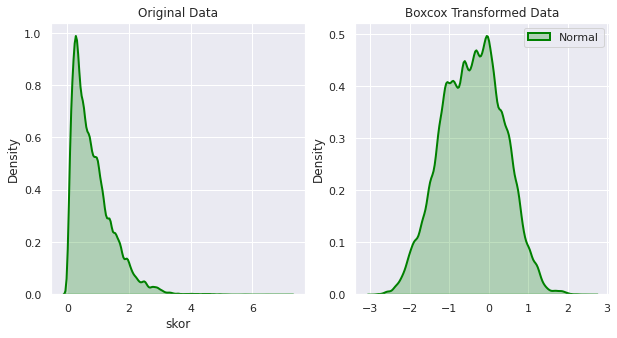

In [75]:
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# transform training data & save lambda value
data_bx, fitted_lambda = stats.boxcox(df1['skor'])
 
fig, ax = plt.subplots(1, 2)
 
# plotting the original data(non-normal) and
# fitted data (normal)
sns.distplot(df1['skor'], hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "Non-Normal", color ="green", ax = ax[0])
 
sns.distplot(data_bx, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "Normal", color ="green", ax = ax[1])
 
# adding legends to the subplots
plt.legend(loc = "upper right")
 
# rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(10)

#add title to each histogram
ax[0].set_title('Original Data')
ax[1].set_title('Boxcox Transformed Data')
 
print(f"Lambda value used for Transformation: {fitted_lambda}")

In [76]:
shapiro(data_bx)

ShapiroResult(statistic=0.9968959093093872, pvalue=0.0)

Text(0.5, 1.0, 'Skor distribution')

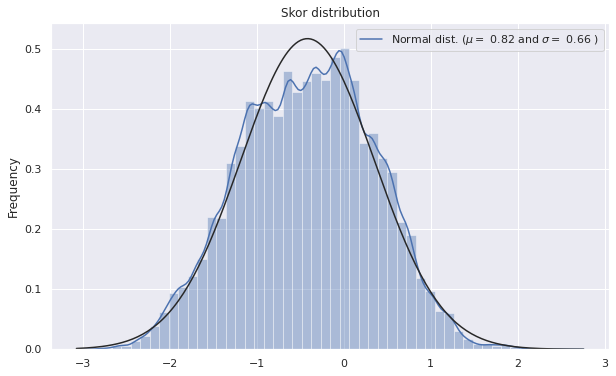

In [77]:
sns.distplot(data_bx, fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df1['skor'])

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Skor distribution')

## SquareRoot Transformation

Text(0.5, 1.0, 'Squareroot Transformed Data')

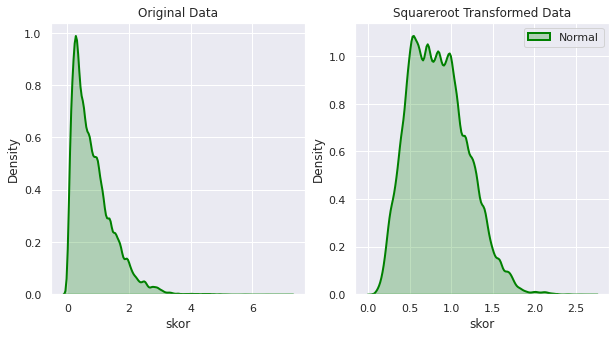

In [78]:
import numpy as np
import matplotlib.pyplot as plt

#create log-transformed data
data_sq = np.sqrt(df1['skor'])

fig, ax = plt.subplots(1, 2)
 
# plotting the original data(non-normal) and
# fitted data (normal)
sns.distplot(df1['skor'], hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "Non-Normal", color ="green", ax = ax[0])
 
sns.distplot(data_sq, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "Normal", color ="green", ax = ax[1])
 
# adding legends to the subplots
plt.legend(loc = "upper right")
 
# rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(10)

#add title to each histogram
ax[0].set_title('Original Data')
ax[1].set_title('Squareroot Transformed Data')

In [79]:
shapiro(data_sq)

ShapiroResult(statistic=0.9823850393295288, pvalue=0.0)

Text(0.5, 1.0, 'Skor distribution')

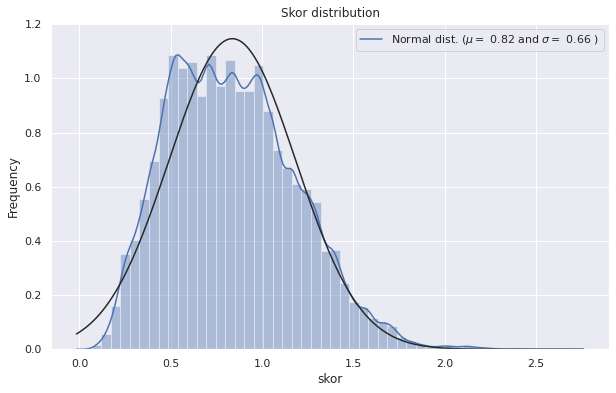

In [80]:
sns.distplot(data_sq, fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df1['skor'])

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Skor distribution')

## Reciprocal Transformation

Text(0.5, 1.0, 'Reciprocal Transformed Data')

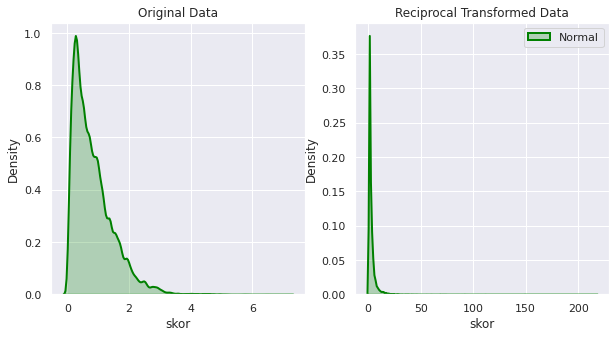

In [81]:
import numpy as np
import matplotlib.pyplot as plt

#create log-transformed data
data_rp = np.reciprocal(df['skor'])

fig, ax = plt.subplots(1, 2)
 
# plotting the original data(non-normal) and
# fitted data (normal)
sns.distplot(df['skor'], hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "Non-Normal", color ="green", ax = ax[0])
 
sns.distplot(data_rp, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "Normal", color ="green", ax = ax[1])
 
# adding legends to the subplots
plt.legend(loc = "upper right")
 
# rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(10)

#add title to each histogram
ax[0].set_title('Original Data')
ax[1].set_title('Reciprocal Transformed Data')

In [82]:
shapiro(data_rp)

ShapiroResult(statistic=0.41192352771759033, pvalue=0.0)

In [83]:
df_sq = pd.DataFrame(data_sq)

df1["skor_sqfit"] = df_sq
df1.head()

,AGIRLIK,Depo_Sevk_Hızı(Gün),skor,skor_sqfit
0,11.0,6.0,1.000153,1.000077
1,11.0,3.0,1.630270,1.276820
2,11.0,9.0,0.799084,0.893915
3,11.0,7.0,0.924857,0.961695
4,11.0,6.0,1.010913,1.005442


In [84]:
# df_bx = pd.DataFrame(data_bx)

# df1["skor_bxfit"] = df_bx
# df1.head()

In [85]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290416 entries, 0 to 324452
Data columns (total 4 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   AGIRLIK              290416 non-null  float64
 1   Depo_Sevk_Hızı(Gün)  290416 non-null  float64
 2   skor                 290416 non-null  float64
 3   skor_sqfit           290416 non-null  float64
dtypes: float64(4)
memory usage: 11.1 MB


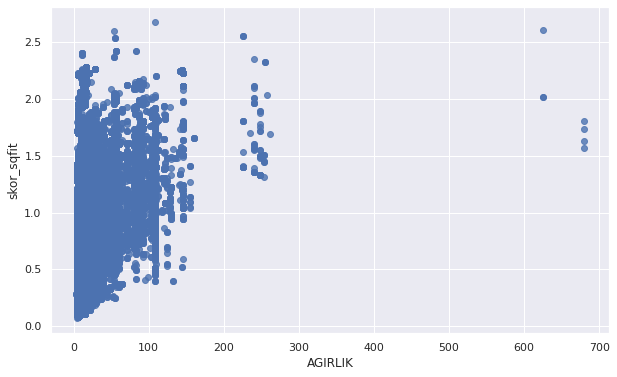

In [86]:
sns.regplot(x="AGIRLIK", y="skor_sqfit", data=df1, fit_reg=False)

In [87]:
df1[df1["AGIRLIK"] > 300]

,AGIRLIK,Depo_Sevk_Hızı(Gün),skor,skor_sqfit
317640,625.0,1.0,6.808013,2.609217
322379,679.2,27.0,3.265586,1.807093
322380,679.2,52.0,2.640668,1.625013
322381,679.2,64.0,2.449516,1.565093
322382,679.2,35.0,3.023057,1.738694
323632,625.0,11.0,4.075639,2.018821
323633,625.0,11.0,4.075660,2.018826


In [88]:
df[df["AGIRLIK"] > 300]["material_id"].unique()

array([73095, 19371, 84657])

In [89]:
df[df["material_id"] == 73095]

,Serial_id,Serial_no,Material_code,prod_date,sup_id,out_date,delivery_doc_no,dlv_date,Stok,material_id,...,Güç [kW],Verim Sınıfı,Gövde,Yapı Şekli,Kutup Sayısı,AGIRLIK,TOPLAM_AGIRLIK,Depo_Sevk_Hızı(Gün),skor-1,skor
317640,1722491,MP01333434,V2EG280M4EB3549,2019-07-02 15:16:54.460,1725837.0,2019-07-03 07:52:24.300,NaN,2019-05-31 00:00:00.000,NaN,73095,...,110.0,IE2,280M,Al,4P,625.0,625.0,0.691318,904.070729,6.808013


In [90]:
df[df["material_id"] == 19371]

,Serial_id,Serial_no,Material_code,prod_date,sup_id,out_date,delivery_doc_no,dlv_date,Stok,material_id,...,Güç [kW],Verim Sınıfı,Gövde,Yapı Şekli,Kutup Sayısı,AGIRLIK,TOPLAM_AGIRLIK,Depo_Sevk_Hızı(Gün),skor-1,skor
322379,102752,MP00095423,MT4YVV1490000,2017-08-09 09:14:28.237,33602.0,2017-09-05 08:12:53.350,NaN,2017-07-31 00:00:00.000,NaN,19371,...,90.0,IE2,280M,PİK,4P,679.2,679.2,26.957235,25.195462,3.265586
322380,102755,MP00095426,MT4YVV1490000,2017-08-09 09:14:19.520,162075.0,2017-09-30 12:58:25.900,0070040058,2017-09-27 00:00:00.000,NaN,19371,...,90.0,IE2,280M,PİK,4P,679.2,679.2,52.155629,13.022564,2.640668
322381,39149,MP00032622,MT4YVV1490000,2017-07-28 08:39:12.817,162075.0,2017-09-30 12:58:25.900,NaN,2017-09-27 00:00:00.000,NaN,19371,...,90.0,IE2,280M,PİK,4P,679.2,679.2,64.180013,10.582734,2.449516
322382,45676,MP00038855,MT4YVV1490000,2017-08-01 14:35:10.973,33602.0,2017-09-05 08:12:53.350,NaN,2017-07-31 00:00:00.000,NaN,19371,...,90.0,IE2,280M,PİK,4P,679.2,679.2,34.734518,19.554035,3.023057


In [91]:
df[df["material_id"] == 84657]

,Serial_id,Serial_no,Material_code,prod_date,sup_id,out_date,delivery_doc_no,dlv_date,Stok,material_id,...,Güç [kW],Verim Sınıfı,Gövde,Yapı Şekli,Kutup Sayısı,AGIRLIK,TOPLAM_AGIRLIK,Depo_Sevk_Hızı(Gün),skor-1,skor
323632,2425629,MP01700337,V2EG280M4B0000,2019-12-30 13:04:46.227,2426796.0,2020-01-10 08:12:00.313,0070068286,2020-01-09 00:00:00.000,NaN,84657,...,90.0,IE2,280M,Al,4P,625.0,2500.0,10.796691,57.888108,4.075639
323633,2425628,MP01700336,V2EG280M4B0000,2019-12-30 13:05:05.877,2426796.0,2020-01-10 08:12:00.313,0070068286,2020-01-09 00:00:00.000,NaN,84657,...,90.0,IE2,280M,Al,4P,625.0,2500.0,10.796463,57.889327,4.075660


## Min-Max Scaling

In [92]:
from sklearn.preprocessing import MinMaxScaler
df1_columns = df1.columns
scaler = MinMaxScaler()
df2 = scaler.fit_transform(df1)

# rename columns (since now its an np array)
df2 = pd.DataFrame(df2)
df2.columns = df1_columns

df2 = df2.drop("skor", axis=1)
df2.head()

,AGIRLIK,Depo_Sevk_Hızı(Gün),skor_sqfit
0,0.010514,0.004525,0.357356
1,0.010514,0.002262,0.463442
2,0.010514,0.006787,0.316660
3,0.010514,0.005279,0.342643
4,0.010514,0.004525,0.359413


In [93]:
df2[df2["AGIRLIK"] > 0.6]

,AGIRLIK,Depo_Sevk_Hızı(Gün),skor_sqfit
284462,0.919739,0.000754,0.974199
288646,1.000000,0.020362,0.666716
288647,1.000000,0.039216,0.596917
288648,1.000000,0.048265,0.573948
288649,1.000000,0.026395,0.640496
289736,0.919739,0.008296,0.747879
289737,0.919739,0.008296,0.747881


## Correlation Matrix

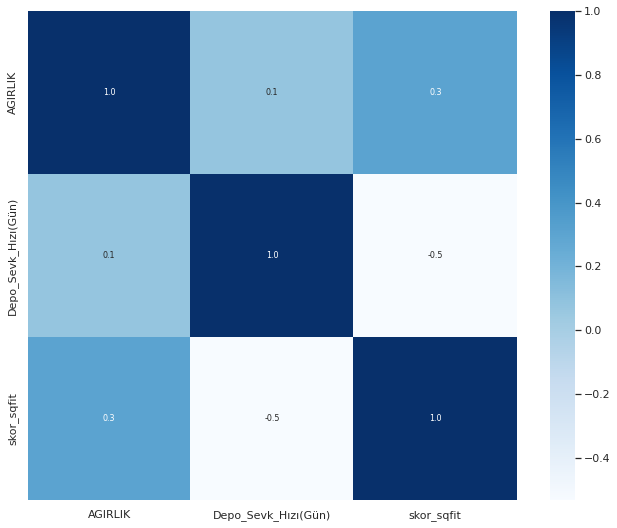

In [94]:
corr = df2.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corr, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':8}, cmap='Blues')

## Features-Label Plots

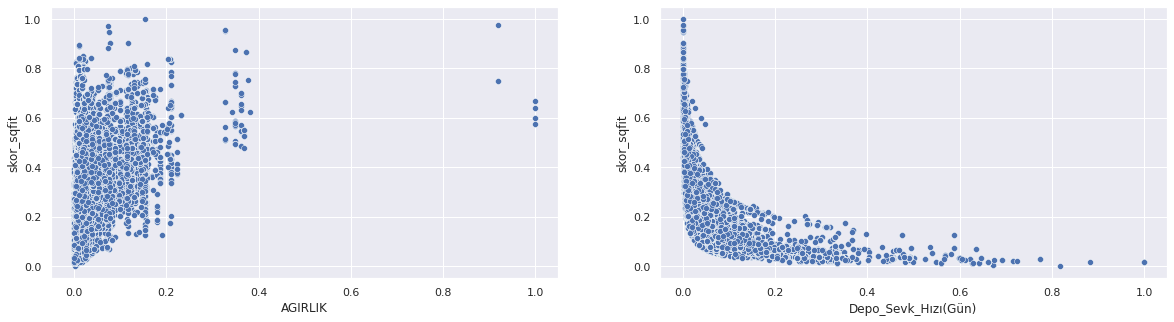

In [95]:
fig, ax = plt.subplots(1, 2)

sns.scatterplot(x = 'AGIRLIK', y = "skor_sqfit", data = df2, ax = ax[0])
sns.scatterplot(x = 'Depo_Sevk_Hızı(Gün)', y = "skor_sqfit", data = df2, ax = ax[1])

fig.set_figheight(5)
fig.set_figwidth(20)
plt.show()

# Score Prediction Models according to weight and shipping speed

## Linear regression without cross validation

In [96]:
X = df2[["AGIRLIK", "Depo_Sevk_Hızı(Gün)"]].values

y = df2["skor_sqfit"].values

In [97]:
X.shape

(290416, 2)

In [98]:
y.shape

(290416,)

In [99]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state = 10)

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

203291
87125
203291
87125


In [100]:
from sklearn.preprocessing import PolynomialFeatures

# fit multiple polynomial features
degrees = [1, 2, 3, 6, 10, 20]

# initialise y_train_pred and y_test_pred matrices to store the train and test predictions
# each row is a data point, each column a prediction using a polynomial of some degree
y_train_pred = np.zeros((len(X_train), len(degrees)))
y_test_pred = np.zeros((len(X_test), len(degrees)))

for i, degree in enumerate(degrees):
    
    # make pipeline: create features, then feed them to linear_reg model
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train, y_train)
    
    # predict on test and train data
    # store the predictions of each degree in the corresponding column
    y_train_pred[:, i] = model.predict(X_train)
    y_test_pred[:, i] = model.predict(X_test)

In [101]:
# compare r2 for train and test sets (for all polynomial fits)
print("R-squared values: \n")

for i, degree in enumerate(degrees):
    train_r2 = round(r2_score(y_train, y_train_pred[:, i]), 2)
    test_r2 = round(r2_score(y_test, y_test_pred[:, i]), 2)
    print("Polynomial degree {0}: train score={1}, test score={2}".format(degree, 
                                                                         train_r2, 
                                                                         test_r2))

R-squared values: 

Polynomial degree 1: train score=0.41, test score=0.41
Polynomial degree 2: train score=0.59, test score=0.61
Polynomial degree 3: train score=0.7, test score=0.7
Polynomial degree 6: train score=0.88, test score=0.86
Polynomial degree 10: train score=0.95, test score=-2244.25
Polynomial degree 20: train score=0.97, test score=-13426222400947.9


In 10 and 20 degree polynomial regression, the model predicts the train data very well, but it predicts very poorly on the new data, so the model is overfitting.

In [102]:
# Best score is obtained on the 6 degrees polynomial regression
score=r2_score(y_test,y_test_pred[:, 3])
round(score, 2)

0.86

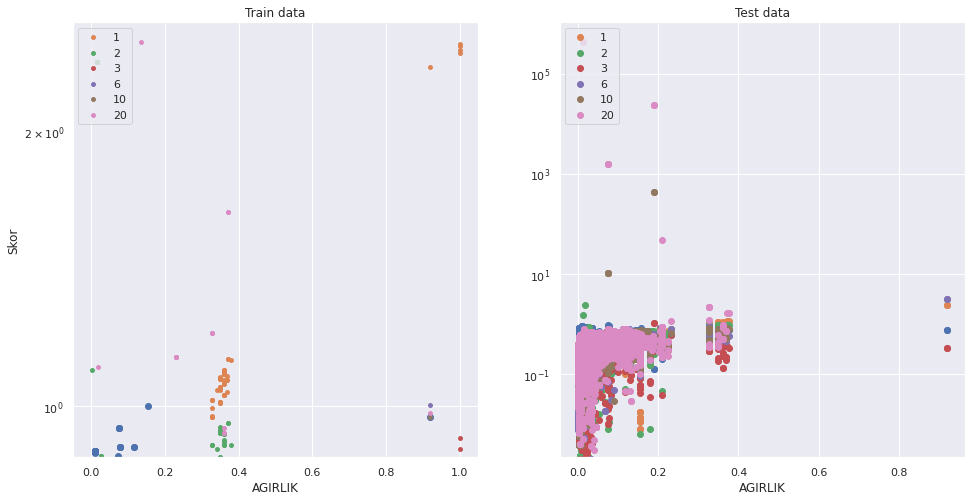

In [103]:
plt.figure(figsize=(16, 8))

# train data
plt.subplot(121)
plt.scatter(X_train[:, 0], y_train)
plt.xlabel("AGIRLIK")
plt.ylabel("Skor")
plt.yscale('log')
plt.title("Train data")
for i, degree in enumerate(degrees):    
    plt.scatter(X_train[:, 0], y_train_pred[:, i], s=15, label=str(degree))
    plt.legend(loc='upper left')
    
# test data
plt.subplot(122)
plt.scatter(X_test[:, 0], y_test)
plt.xlabel("AGIRLIK")
plt.yscale('log')
plt.title("Test data")
for i, degree in enumerate(degrees):    
    plt.scatter(X_test[:, 0], y_test_pred[:, i], label=str(degree))
    plt.legend(loc='upper left')

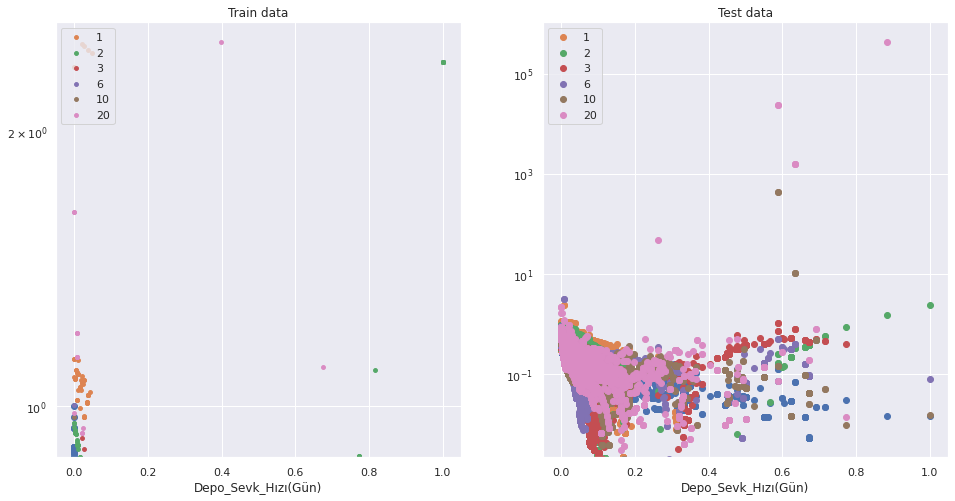

In [104]:
plt.figure(figsize=(16, 8))

# train data
plt.subplot(121)
plt.scatter(X_train[:, 1], y_train)
plt.xlabel("Depo_Sevk_Hızı(Gün)")
plt.yscale('log')
plt.title("Train data")
for i, degree in enumerate(degrees):    
    plt.scatter(X_train[:, 1], y_train_pred[:, i], s=15, label=str(degree))
    plt.legend(loc='upper left')
    
# test data
plt.subplot(122)
plt.scatter(X_test[:, 1], y_test)
plt.xlabel("Depo_Sevk_Hızı(Gün)")
plt.yscale('log')
plt.title("Test data")
for i, degree in enumerate(degrees):    
    plt.scatter(X_test[:, 1], y_test_pred[:, i], label=str(degree))
    plt.legend(loc='upper left')

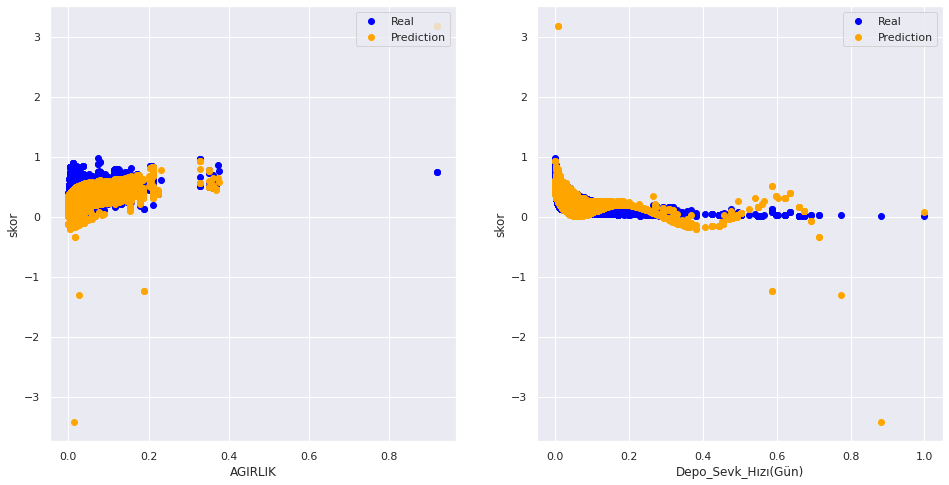

In [105]:
plt.figure(figsize=(16, 8)) 

# fist plot:
plt.subplot(121)
plt.scatter(X_test[:, :1], y_test, c='blue')
plt.scatter(X_test[:, :1], y_test_pred[:, 3], c='orange')
plt.xlabel("AGIRLIK")
plt.ylabel("skor")
plt.legend(["Real", "Prediction"], loc ="upper right")
 
# second plot
plt.subplot(122)
plt.scatter(X_test[:, 1:], y_test, c='blue')
plt.scatter(X_test[:, 1:], y_test_pred[:, 3], c='orange')
plt.xlabel("Depo_Sevk_Hızı(Gün)")
plt.ylabel("skor")
plt.legend(["Real", "Prediction"], loc ="upper right")

plt.show()

## Ridge Regression

In [106]:
from sklearn.preprocessing import PolynomialFeatures

# fit multiple polynomial features
degrees = [1, 2, 3, 6, 10, 20]

# initialise y_train_pred and y_test_pred matrices to store the train and test predictions
# each row is a data point, each column a prediction using a polynomial of some degree
y_train_pred = np.zeros((len(X_train), len(degrees)))
y_test_pred = np.zeros((len(X_test), len(degrees)))

for i, degree in enumerate(degrees):
    
    # make pipeline: create features, then feed them to linear_reg model
    model_r = make_pipeline(PolynomialFeatures(degree), Ridge(alpha = 0.001))
    model_r.fit(X_train, y_train)
    
    # predict on test and train data
    # store the predictions of each degree in the corresponding column
    y_train_pred[:, i] = model_r.predict(X_train)
    y_test_pred[:, i] = model_r.predict(X_test)

In [107]:
# compare r2 for train and test sets (for all polynomial fits)
print("R-squared values: \n")

for i, degree in enumerate(degrees):
    train_r2 = round(r2_score(y_train, y_train_pred[:, i]), 2)
    test_r2 = round(r2_score(y_test, y_test_pred[:, i]), 2)
    print("Polynomial degree {0}: train score={1}, test score={2}".format(degree, 
                                                                         train_r2, 
                                                                         test_r2))

R-squared values: 

Polynomial degree 1: train score=0.41, test score=0.41
Polynomial degree 2: train score=0.59, test score=0.61
Polynomial degree 3: train score=0.7, test score=0.7
Polynomial degree 6: train score=0.81, test score=0.81
Polynomial degree 10: train score=0.81, test score=0.81
Polynomial degree 20: train score=0.82, test score=0.81


## Grid Search with Ridge Regression

In [108]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

param_grid = [
    {'poly__degree': np.arange(8),
     'ridge__alpha': [0.0001, 0.001,0.01, 0.1, 1, 10]}
  ]
pipeline = Pipeline(steps=[('poly', PolynomialFeatures()), ('ridge', Ridge())])
grid_search = GridSearchCV(pipeline, param_grid, cv=5,
                           scoring='r2',
                           return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             param_grid=[{'poly__degree': array([0, 1, 2, 3, 4, 5, 6, 7]),
                          'ridge__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}],
             return_train_score=True, scoring='r2')

In [109]:
grid_search.best_params_

{'poly__degree': 7, 'ridge__alpha': 0.0001}

In [110]:
model_ridge = make_pipeline(PolynomialFeatures(7), Ridge(alpha=0.0001))

model_ridge.fit(X_train, y_train)

y_pred = model_ridge.predict(X_test)

round(model_ridge.score(X_test, y_test), 2)

0.84

Linear regression with L2 regularization (Ridge) did not increase the model prediction score. In fact, since it reduces model performance slightly, the linear model with polynomial features will be used.

## Cross Validation

* In the section "Linear regression without cross validation",  best score is obtained on the 6 degrees polynomial regression.

### KFold Cross Validation

In [111]:
cv_kfold = KFold(n_splits=10, random_state=1, shuffle=True)

model_kfold = make_pipeline(PolynomialFeatures(6), LinearRegression())

scores_kfold = cross_val_score(model_kfold, X_train, y_train, scoring='r2', cv=cv_kfold, n_jobs=-1)

print('R2 Mean :', abs(scores_kfold).mean())
print('R2 Std :' , abs(scores_kfold).std())

R2 Mean : 2.2926284767820686
R2 Std : 4.479631101025597


In [112]:
scores_kfold

array([  0.88199889,   0.87875305,   0.88036133,   0.7542254 ,
         0.88115722,   0.8738133 , -15.7217756 ,   0.87704309,
         0.303876  ,   0.87328089])

### RepeatedKFold Cross Validation

In [113]:
cv_rkfold = RepeatedKFold(n_splits=4, n_repeats=5, random_state=1)
# create model
model_rkfold = make_pipeline(PolynomialFeatures(6), LinearRegression())
# evaluate model
scores_rkfold = cross_val_score(model_rkfold, X_train, y_train, scoring='r2', cv=cv_rkfold, n_jobs=-1)
# report performance
print('R2 Mean :', abs(scores_rkfold).mean())
print('R2 Std :' , abs(scores_rkfold).std())

R2 Mean : 2.637793362461744
R2 Std : 3.252159124208807


In [114]:
scores_rkfold

array([  0.88008099,   0.83103462,  -5.60591585,   0.65611168,
         0.82884681,   0.87888489,  -6.27063771,   0.81800276,
       -13.62715175,   0.87528091,  -5.45621759,   0.87987092,
        -6.48996529,   0.81870155,   0.88039294,   0.83418348,
         0.88277071,  -3.51910499,   0.87678263,   0.84592918])

### ShuffleSplit Cross Validation

In [115]:
rs = ShuffleSplit(n_splits=4, random_state=0)
model_rs = make_pipeline(PolynomialFeatures(6), LinearRegression())
# evaluate model
scores_shuffle = cross_val_score(model_rs, X_train, y_train, scoring='r2', cv=rs, n_jobs=-1)
# report performance
print('R2 Mean :', abs(scores_shuffle).mean())
print('R2 Std :' , abs(scores_shuffle).std())

R2 Mean : 0.8783320618157988
R2 Std : 0.005161516219062997


In [116]:
scores_shuffle

array([0.87902555, 0.88003889, 0.88421322, 0.87005059])

### TimeSeriesSplit Cross Validation

In [117]:
ts = TimeSeriesSplit(n_splits=5)
model_ts = make_pipeline(PolynomialFeatures(6), LinearRegression())
# evaluate model
scores_tscv = cross_val_score(model_ts, X_train, y_train, scoring='r2', cv=ts, n_jobs=-1)
# report performance
print('R2 Mean :', abs(scores_tscv).mean())
print('R2 Std :' , abs(scores_tscv).std())

R2 Mean : 36904.06376931143
R2 Std : 73802.42067584135


In [118]:
scores_tscv

array([-1.84508905e+05, -8.87747646e+00,  8.51968440e-01,  8.02041206e-01,
        8.82370585e-01])

* The ShuffleSplit cross validation method with the highest R2 score mean is selected.

In [119]:
model_rs.fit(X_train, y_train)
y_pred = model_rs.predict(X_test)
print("R2 Score: {}".format(round(r2_score(y_test, y_pred), 2)))

R2 Score: 0.86


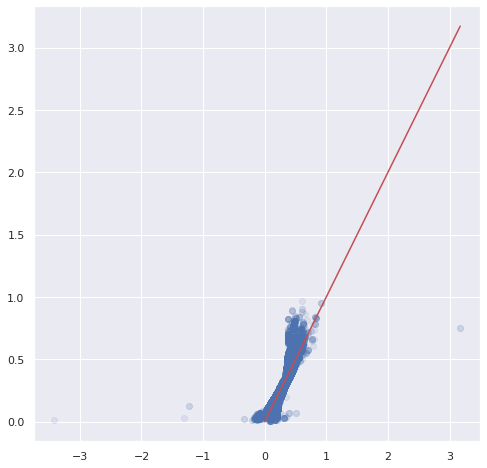

In [120]:
def visualize(pred, actual):
    plt.figure(figsize=(8,8))
    plt.scatter(pred, actual, alpha=0.1)
    Mx = max([max(pred),max(actual)])
    plt.plot([0,Mx],[0,Mx],"r")
    plt.show()

visualize(y_pred, y_test)

## LightGBM

In [121]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_log_error
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score

In [122]:
def calc_results(actual, pred):
    result = {}
    result['MSE'] = mean_squared_error(actual, pred)
    result['MAE'] = mean_absolute_error(actual, pred)
    result['RMSE'] = (mean_squared_error(actual, pred)**0.5)
    result['R2'] = r2_score(actual, pred)
    return result

In [123]:
# model = lgb.LGBMRegressor(learning_rate=0.09,max_depth=-5,random_state=42) 

model = lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=20) 

model.fit(X_train , y_train)
y_pred = model.predict(X_test)

calc_results(y_test, y_pred)

{'MSE': 0.002604579641288432,
 'MAE': 0.040956386633270316,
 'RMSE': 0.0510350824559776,
 'R2': 0.8538003043276408}

## Cross Validation

### KFold Cross Validation

In [124]:
cv_kfold = KFold(n_splits=10, random_state=1, shuffle=True)

model_kfold = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.05, n_estimators=20)

scores_kfold = cross_val_score(model_kfold, X_train, y_train, scoring='r2', cv=cv_kfold, n_jobs=-1)

print('R2 Mean :', abs(scores_kfold).mean())
print('R2 Std :' , abs(scores_kfold).std())

R2 Mean : 0.8532955563761915
R2 Std : 0.0005767746539499057


In [125]:
scores_kfold

array([0.85331792, 0.8541023 , 0.8530153 , 0.85357062, 0.85220394,
       0.85385074, 0.85265128, 0.85357074, 0.85282297, 0.85384976])

### RepeatedKFold Cross Validation

In [126]:
cv_rkfold = RepeatedKFold(n_splits=4, n_repeats=5, random_state=1)
# create model
model_rkfold = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.05, n_estimators=20)
# evaluate model
scores_rkfold = cross_val_score(model_rkfold, X_train, y_train, scoring='r2', cv=cv_rkfold, n_jobs=-1)
# report performance
print('R2 Mean :', abs(scores_rkfold).mean())
print('R2 Std :' , abs(scores_rkfold).std())

R2 Mean : 0.8532241775258009
R2 Std : 0.00023965724337813863


In [127]:
scores_rkfold

array([0.8534333 , 0.85287719, 0.85313901, 0.85334029, 0.85321664,
       0.85341435, 0.85352675, 0.85286905, 0.85330697, 0.85288961,
       0.85336533, 0.85328561, 0.85324687, 0.85262864, 0.85343724,
       0.85344738, 0.85312502, 0.85307444, 0.85342131, 0.85343855])

### ShuffleSplit Cross Validation

In [128]:
rs = ShuffleSplit(n_splits=4, random_state=0)
model_rs = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.05, n_estimators=20)
# evaluate model
scores_shuffle = cross_val_score(model_rs, X_train, y_train, scoring='r2', cv=rs, n_jobs=-1)
# report performance
print('R2 Mean :', abs(scores_shuffle).mean())
print('R2 Std :' , abs(scores_shuffle).std())

R2 Mean : 0.8529539420615513
R2 Std : 0.0004394218510674928


In [129]:
scores_shuffle

array([0.85237975, 0.8533252 , 0.8534324 , 0.85267841])

### TimeSeriesSplit Cross Validation

In [130]:
ts = TimeSeriesSplit(n_splits=5)
model_ts = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.05, n_estimators=20)
# evaluate model
scores_tscv = cross_val_score(model_ts, X_train, y_train, scoring='r2', cv=ts, n_jobs=-1)
# report performance
print('R2 Mean :', abs(scores_tscv).mean())
print('R2 Std :' , abs(scores_tscv).std())

R2 Mean : 0.8532072037809929
R2 Std : 0.0007532790409247171


In [131]:
scores_tscv

array([0.8538782 , 0.85353601, 0.85175305, 0.85360905, 0.8532597 ])

* All of the cross validation methods above is giving almost same result.

## Hyperparameter Tuning

In [132]:
param_grid = {
    'num_leaves': [7, 14, 21, 28, 31, 50, 100],
    'learning_rate': [0.1, 0.03, 0.003],
    'max_depth': [-1, 3, 5, 4, 50],
    'n_estimators': [50, 100, 200, 500, 10],
    'reg_alpha': [0.0001, 0.001,0.01, 0.1, 1, 10]
              }


from sklearn.model_selection import RandomizedSearchCV
rnd_search = RandomizedSearchCV(lgb.LGBMRegressor(), param_grid, n_iter =10, cv=9)
rnd_search.fit(X_train, y_train)
print(rnd_search.best_params_)
print(rnd_search.best_score_)

{'reg_alpha': 10, 'num_leaves': 100, 'n_estimators': 200, 'max_depth': 50, 'learning_rate': 0.1}
0.9972394328549006


In [133]:
best_params = {
    'num_leaves': 31,
    'learning_rate': 0.1,
    'max_depth': 50,
    'n_estimators': 500,
    'reg_alpha': 0.1
              }

In [134]:
model_latest = lgb.LGBMRegressor(**best_params)

# Evaluate model with test set
model_latest.fit(X_train , y_train)
y_pred = model_latest.predict(X_test)

print(calc_results(y_test, y_pred))

{'MSE': 3.0188538814490204e-05, 'MAE': 0.0027538318733053386, 'RMSE': 0.005494409778537655, 'R2': 0.9983054635314248}


In [135]:
predicted_value = model_latest.predict(X_test)

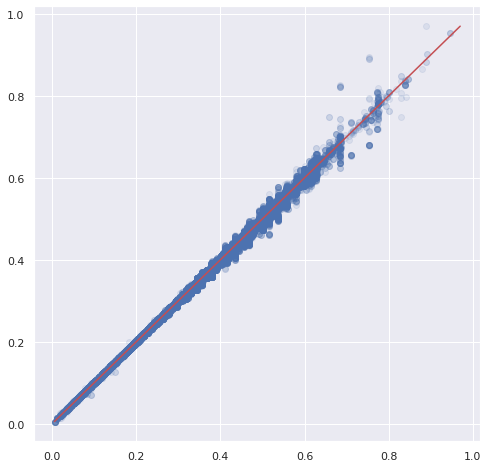

Root mean squared error: 0.0055


In [136]:
def visualize(pred, actual):
    plt.figure(figsize=(8,8))
    plt.scatter(pred, actual, alpha=0.1)
    Mx = max([max(pred),max(actual)])
    Mn = min([min(pred),min(actual)])
    plt.plot([Mn,Mx],[Mn,Mx],"r")
    plt.show()
    
    print('Root mean squared error: %.4f'%mean_squared_error(actual, pred)**0.5)

visualize(predicted_value, y_test)

# Score Predicting Model according to all features of product

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290416 entries, 0 to 324452
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Serial_id            290416 non-null  int64         
 1   Serial_no            290416 non-null  object        
 2   Material_code        290416 non-null  object        
 3   prod_date            290416 non-null  datetime64[ns]
 4   sup_id               290416 non-null  float64       
 5   out_date             290416 non-null  datetime64[ns]
 6   delivery_doc_no      136107 non-null  object        
 7   dlv_date             290416 non-null  object        
 8   Stok                 61 non-null      object        
 9   material_id          290416 non-null  int64         
 10  material no          290416 non-null  object        
 11  definition           290416 non-null  object        
 12  Güç [kW]             290416 non-null  object        
 13  Verim Sınıfı  

In [138]:
all_df = df.iloc[:, 12::]
all_df.head()

,Güç [kW],Verim Sınıfı,Gövde,Yapı Şekli,Kutup Sayısı,AGIRLIK,TOPLAM_AGIRLIK,Depo_Sevk_Hızı(Gün),skor-1,skor
0,0.55,YOK,90S,Al,4P,11.0,514.858407,6.400192,1.718698,1.000153
1,0.55,YOK,90S,Al,4P,11.0,514.858407,2.679494,4.105253,1.630270
2,0.55,YOK,90S,Al,4P,11.0,514.858407,8.990569,1.223504,0.799084
3,0.55,YOK,90S,Al,4P,11.0,514.858407,7.229669,1.521508,0.924857
4,0.55,YOK,90S,Al,4P,11.0,514.858407,6.292516,1.748108,1.010913


In [139]:
all_df.isna().sum()

Güç [kW]               0
Verim Sınıfı           0
Gövde                  0
Yapı Şekli             0
Kutup Sayısı           0
AGIRLIK                0
TOPLAM_AGIRLIK         0
Depo_Sevk_Hızı(Gün)    0
skor-1                 0
skor                   0
dtype: int64

In [140]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290416 entries, 0 to 324452
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Güç [kW]             290416 non-null  object 
 1   Verim Sınıfı         290416 non-null  object 
 2   Gövde                290416 non-null  object 
 3   Yapı Şekli           290416 non-null  object 
 4   Kutup Sayısı         290416 non-null  object 
 5   AGIRLIK              290416 non-null  float64
 6   TOPLAM_AGIRLIK       290416 non-null  float64
 7   Depo_Sevk_Hızı(Gün)  290416 non-null  float64
 8   skor-1               290416 non-null  float64
 9   skor                 290416 non-null  float64
dtypes: float64(5), object(5)
memory usage: 24.4+ MB


## Correlation Matrix

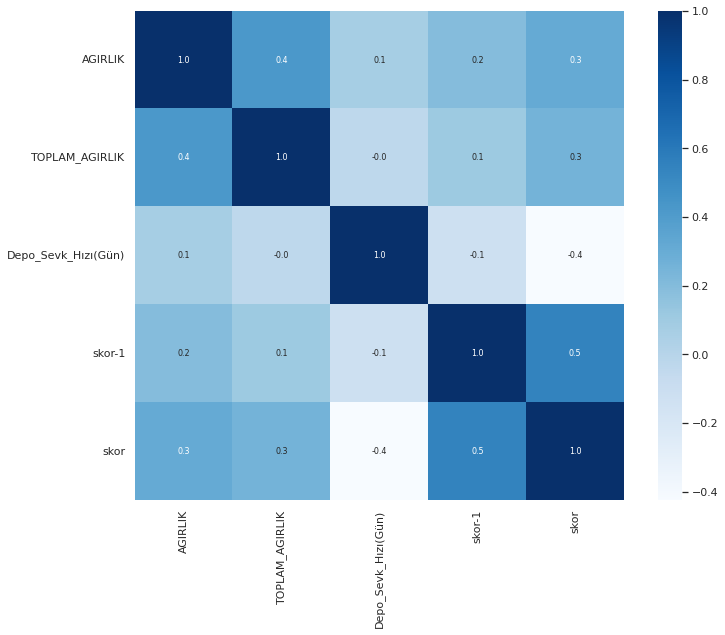

In [141]:
corr = all_df.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corr, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':8}, cmap='Blues')

In [142]:
def uniq_col(df):
  for col in all_df.columns:
    uniq = all_df[col].nunique()
    y = str(col) + ": {}".format(uniq)
    print(y)

uniq_col(all_df)

Güç [kW]: 54
Verim Sınıfı: 4
Gövde: 15
Yapı Şekli: 2
Kutup Sayısı: 4
AGIRLIK: 195
TOPLAM_AGIRLIK: 1407
Depo_Sevk_Hızı(Gün): 290349
skor-1: 290378
skor: 290377


In [143]:
for col in all_df.columns:
  if all_df[col].dtypes == 'object':
    all_df[col] = all_df[col].astype('category')

In [144]:
cols = [col for col in all_df.columns if all_df[col].dtypes == 'category']
cols

['Güç [kW]', 'Verim Sınıfı', 'Gövde', 'Yapı Şekli', 'Kutup Sayısı']

In [145]:
encoded_data = pd.get_dummies(all_df, columns = cols)

In [146]:
encoded_data["skor_sqfit"] = df_sq

In [147]:
encoded_data.shape

(290416, 85)

## Model

In [148]:
X1 = encoded_data.drop(['skor','skor_sqfit'], axis=1)
y1 = encoded_data["skor_sqfit"].values

In [149]:
X1.shape

(290416, 83)

In [150]:
y1.shape

(290416,)

In [151]:
# X = df3.drop(['skor','skor_sqfit'], axis=1)
# y = df3["skor_sqfit"].values

In [152]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.20, shuffle=False)

In [154]:
from sklearn.preprocessing import PolynomialFeatures
    
# make pipeline: create features, then feed them to linear_reg model
model = make_pipeline(PolynomialFeatures(6), LinearRegression())
model.fit(X_train1, y_train1)

# predict on test and train data
# store the predictions of each degree in the corresponding column
y_train_pred = model.predict(X_train1)
y_test_pred = model.predict(X_test1)

MemoryError: ignored

In [ ]:
# compare r2 for train and test sets (for all polynomial fits)
print("R-squared values: \n")

for i, degree in enumerate(degrees):
    train_r2 = round(r2_score(y_train1, y_train_pred[:, i]), 2)
    test_r2 = round(r2_score(y_test1, y_test_pred[:, i]), 2)
    print("Polynomial degree {0}: train score={1}, test score={2}".format(degree, 
                                                                         train_r2, 
                                                                         test_r2))

In [ ]:
def visualize(pred, actual):
    plt.figure(figsize=(8,8))
    plt.scatter(pred, actual, alpha=0.1)
    Mx = max([max(pred),max(actual)])
    plt.plot([0,Mx],[0,Mx],"r")
    plt.show()

visualize(y_test_pred[:, i], y_test)